# Gas Lifted Wells model analysis


In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from optimization.rto import RTO
from optimization.batch_profile_optimizer import BatchProfileOptimizer
from model.adaptation.ma_gaussian_processes import MAGaussianProcesses
from model.process.gas_lifted_wells import GasLiftwedWellSystem


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



In [ ]:
def input_decision_surface_2D(gs, noise=0.01, grid_size=50):
    fig, ax = plt.subplots(3, 1, figsize=(8,10))

    u1 = np.linspace(0.5, 5.0, grid_size)
    u2 = np.linspace(0.5, 5.0, grid_size)

    xx, yy = np.meshgrid(u1, u2)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    cost_quad = np.array([gs.get_objective_quadratic(x, noise) for x in grid])
    cost_linear = np.array([gs.get_objective_linear(x, noise) for x in grid])
    g = np.array([gs.get_constraints(x, noise)[0] for x in grid])
    # reshape the predictions back into a grid
    zz_cost_quad = cost_quad.reshape(xx.shape)
    zz_cost_linear = cost_linear.reshape(xx.shape)
    zz_g = g.reshape(xx.shape)

    CS = ax[0].contourf(xx, yy, zz_cost_quad)
    fig.colorbar(CS, ax=ax[0])
    CS = ax[1].contourf(xx, yy, zz_cost_linear)
    fig.colorbar(CS, ax=ax[1])
    CS = ax[2].contourf(xx, yy, zz_g, cmap='jet')
    fig.colorbar(CS, ax=ax[2])

    ax[0].set_title('Fobj (Quadratic)')
    ax[1].set_title('Fobj (Linear)')
    ax[2].set_title('$Restriction (w_g^T)$')

def input_decision_surface_1D(gs, noise=0.01, grid_size=50):
    fig, ax = plt.subplots(3, 1, figsize=(8,10))
    grid = np.linspace(0.5, 5.0, grid_size)
    # make predictions for the grid
    cost_quad = np.array([gs.get_objective_quadratic(np.array([x]), noise) for x in grid])
    cost_linear = np.array([gs.get_objective_linear(np.array([x]), noise) for x in grid])
    g = np.array([gs.get_constraints(np.array([x]), noise)[0] for x in grid])
    # reshape the predictions back into a grid
  
    ax[0].plot(grid, cost_quad)
    ax[1].plot(grid, cost_linear)
    ax[2].plot(grid, g)

    ax[0].set_title('Fobj (Quadratic)')
    ax[1].set_title('Fobj (Linear)')
    ax[2].set_title('$Restriction (w_g^T)$')

In [ ]:
def PI_decision_surface(x, PI=[1.5,7.0], noise=0.01, grid_size=50):
    fig, ax = plt.subplots(3,1,figsize=(8,10))

    u1 = np.linspace(PI[0], PI[1], grid_size)
    u2 = np.linspace(PI[0], PI[1], grid_size)

    xx, yy = np.meshgrid(u1, u2)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    models = []
    for x in grid:
        config = { 'well1': { 'GOR': 0.1, 'PI': x[0], 'rho_o': 900 },
            'well2': { 'GOR': 0.15, 'PI': x[1], 'rho_o': 800}} 
        models.append(GasLiftwedWellSystem(config))
    # make predictions for the grid
    cost_quad = np.array([gs.get_objective_quadratic(x, noise) for gs in models])
    cost_linear = np.array([gs.get_objective_linear(x, noise) for gs in models])
    g = np.array([gs.get_constraints(x, noise)[0] for gs in models])
    # reshape the predictions back into a grid
    zz_cost_quad = cost_quad.reshape(xx.shape)
    zz_cost_linear = cost_linear.reshape(xx.shape)
    zz_g = g.reshape(xx.shape)

    CS = ax[0].contourf(xx, yy, zz_cost_quad)
    fig.colorbar(CS, ax=ax[0])
    CS = ax[1].contourf(xx, yy, zz_cost_linear)
    fig.colorbar(CS, ax=ax[1])
    CS = ax[2].contourf(xx, yy, zz_g, cmap='jet')
    fig.colorbar(CS, ax=ax[2])

    ax[0].set_title('Fobj (Quadratic)')
    ax[1].set_title('Fobj (Linear)')
    ax[2].set_title('$Restriction (w_g^T)$')

In [ ]:
config = { 'well1': { 'GOR': 0.1, 'PI': 3.5, 'rho_o': 900, 'p_res': 150 }} 
gs = GasLiftwedWellSystem(config)

In [ ]:
well_sim = gs.simulate([2,2])
well_ss = gs.get_steady_state([2,2])
col_names = ['m_ga', 'm_gt', 'm_ot', 'w_pg', 'w_po', 'w_iv', 'w_ro', 'w_rg']

for well_name in well_sim.keys():
    y_sim = well_sim[well_name].y
    t_sim = well_sim[well_name].t
    n_vars = y_sim.shape[0]
    fig, ax = plt.subplots(1, y_sim.shape[0], figsize=(16,6))
    for i in range(n_vars):
        ax[i].plot(t_sim, y_sim[i,:])
        ax[i].set_ylabel(col_names[i])

    fig.suptitle(f'steady-state {well_name}: {well_ss[well_name]}')
    fig.show()

In [ ]:
input_decision_surface_1D(gs,noise=0)
#PI_decision_surface([1,1],noise=0.0)

In [ ]:
config = { 'well1': { 'GOR': 0.1, 'PI': 2.2, 'rho_o': 900, 'p_res': 150 },
          'well2': { 'GOR': 0.1, 'PI': 2.2, 'rho_o': 900, 'p_res': 150 }} 
gs = GasLiftwedWellSystem(config)
gs.numpoints = 3000
col_names = ['m_ga', 'm_gt', 'm_ot', 'w_pg', 'w_po', 'w_iv', 'w_ro', 'w_rg']
# col_names = ['m_ga1', 'm_ga1', 'm_gt1', 'm_gt2', 'm_ot1', 'm_ot2']
y_sim = gs.simulate_casadi(x0=[1,1,1,1,1,1],u=[1,1],tf=1).T
t_sim = np.arange(gs.numpoints)
n_vars = y_sim.shape[0]
fig, ax = plt.subplots(gs.n_w, y_sim.shape[0] / 2, figsize=(16,6))

for k in range(gs.n_w):
    for i in range(n_vars):
        if(i % 2 == 0):
            ax[k, i / 2].plot(t_sim, y_sim[i,:])
        else:
            ax[k, i / 2].plot(t_sim, y_sim[i,:])
    ax[k].set_ylabel(col_names[i])

fig.show()

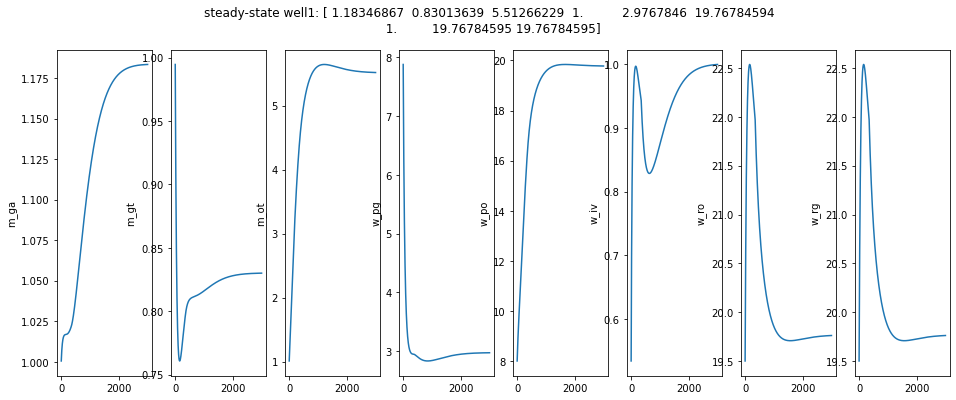

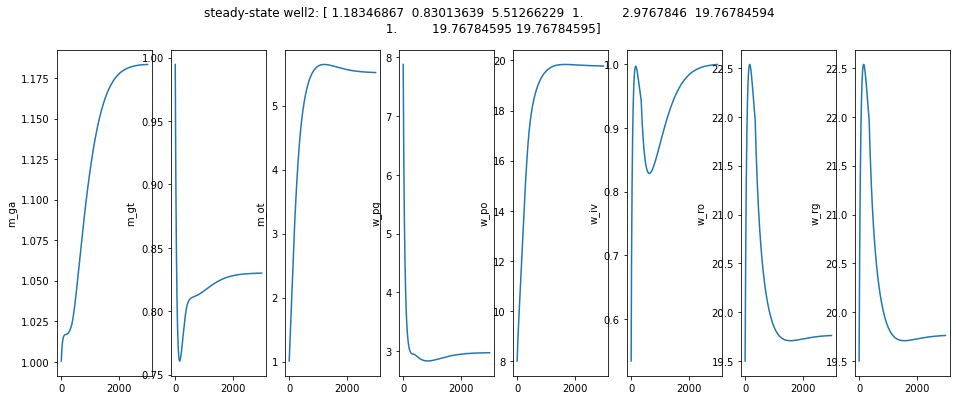

In [10]:
config = { 'well1': { 'GOR': 0.15, 'PI': 3.2, 'rho_o': 900, 'p_res': 150 },
          'well2': { 'GOR': 0.1, 'PI': 3.5, 'rho_o': 800, 'p_res': 150 }} 
gs = GasLiftwedWellSystem(config)
gs.numpoints = 3000
u = [1,1]
well_sim = gs.simulate_casadi(x0=[1,1,1,1,1,1],u=u)
well_ss = gs.get_steady_state_casadi(u)

col_names = ['m_ga', 'm_gt', 'm_ot', 'w_pg', 'w_po', 'w_iv', 'w_ro', 'w_rg', 'u']

for well_name in well_sim.keys():
    y_sim = well_sim[well_name].y
    t_sim = well_sim[well_name].t
    n_vars = y_sim.shape[0]
    fig, ax = plt.subplots(1, y_sim.shape[0], figsize=(16,6))
    for i in range(n_vars):
        ax[i].plot(t_sim, y_sim[i,:])
        ax[i].set_ylabel(col_names[i])

    fig.suptitle(f'steady-state {well_name}: {well_ss[well_name].reshape(-1,)}')
    fig.show()